In [12]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.integrate as spint

#### 1. 

$p(t|\lambda)=e^{-\lambda t}$

Since from $t$ to $t_d$, no particles are detected, the distribution needs to be shifted by $t_d$

$p(t|\lambda, t_d)=e^{-\lambda (t-t_d)}$

#### 2.

*Approach:*
In order to calculate a posterior distribution wrt both $\lambda$ and $t_d$, I extend the method used in part A, to be in three dimensions. Instead of creating one array for the parameter I am hoping to constrain, I create two such arrays, and end up with a 3-array, with dimensions ($\lambda$, $t_d$, pdf). With this, it is easy to plot either a 3d surface plot, or to integrate along both axes to get univariate posterior distributions.

In [13]:
def find_posterior(lam_i, lam_f, t_d_i, t_d_f, measurements, uniform_t_d=True):
    '''Find the posterior distribution of exponential distribution with uniform lambda prior
    between lam_i and lam_f, and either uniform or normal t_d prior'''
    # get inter-arrival times
    inter_times = np.diff(measurements)
    
    # creating arrays of parameter space
    lam_arr = np.linspace(lam_i, lam_f, 500)
    t_d_arr = np.linspace(t_d_i, t_d_f, 500)
    scale_arr = 1/lam_arr
    lam_grid, t_d_grid = np.meshgrid(lam_arr, t_d_arr, indexing='xy')
    
    # prior for lambda is uniform distribution
    prior_lam = 1/(lam_f - lam_i)    
    prior_lam_arr = np.ones(len(lam_arr)) * prior_lam
    
    
    if uniform_t_d:
        # if t_d prior is uniform
        prior_t_d_arr = sps.uniform.pdf(t_d_arr, loc=t_d_i, scale=(t_d_f-t_d_i))
    else:
        # if t_d prior is normal
        mu = 0.097
        sig = 0.013
        prior_t_d_arr = sps.norm.pdf(t_d_arr, loc=mu, scale=sig)
    
    # create a 2d prior array with dimensions [lam, t_d]
    prior = prior_lam_arr.reshape(len(prior_lam_arr),1) * prior_t_d_arr
    
    # define likelyhood distribution: 3-matrix with dimensions [t_d, lam, inter_times]
    dist = sps.expon(loc=t_d_arr.reshape(len(t_d_arr),1,1), scale=scale_arr.reshape(1,len(scale_arr),1))

    # integrate priors to multiply by likelyhood
    prior_lam = np.trapz(prior_lam_arr, lam_arr)
    #! I'm not supposed to integrate here for the normal dist. prior.
    #! I would have to add the prior function into the log_ptheta somehow
    prior_t_d = np.trapz(prior_t_d_arr, t_d_arr)

    # to take product, sum over log pdf, to avoid problem of division by 0
    # since lambda and t_d are independent, priors can be added in separately
    log_ptheta = np.sum(dist.logpdf(inter_times), axis=2) + np.log(prior_lam) + np.log(prior_t_d)
    ptheta = np.exp(log_ptheta - np.amax(log_ptheta))
    
    # to find normalization constant, we need to integrate in both directions, lambda and t_d
    int_ptheta = spint.simpson(prior, lam_grid) * spint.simpson(prior, t_d_grid.T)
    ptheta_norm = ptheta/int_ptheta    

    return lam_grid, t_d_grid, ptheta_norm
    
def plot_ptheta_surface(lam_grid, t_d_grid, ptheta_norm):
    '''Plots 3D surface of the joint posterior distribution'''
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(lam_grid, t_d_grid, ptheta_norm, cmap='viridis', rstride=5, cstride=5)
    ax.set_xlabel('$\lambda$')
    ax.set_ylabel('$t_d$')
    ax.set_zlabel('prob. density')
    plt.show()

<IPython.core.display.Javascript object>


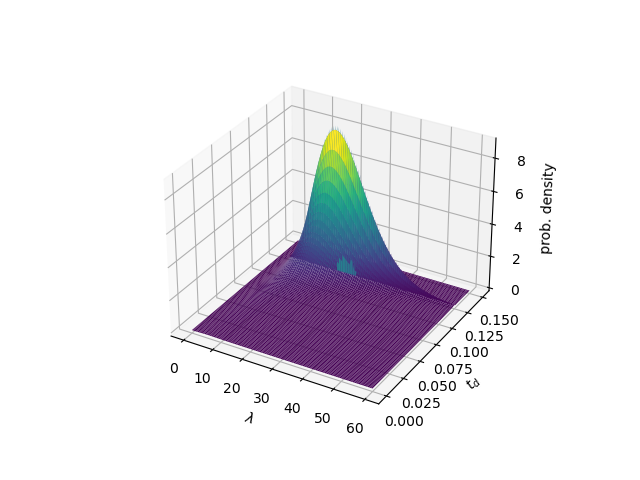

In [14]:
%matplotlib notebook
measurements1 = np.loadtxt('particle_times1.txt')
measurements2 = np.loadtxt('particle_times2.txt')


lam_grid1, t_d_grid1, ptheta1 = find_posterior(0.00001, 60, 0, 0.15, measurements1)
plot_ptheta_surface(lam_grid1, t_d_grid1, ptheta1)

<IPython.core.display.Javascript object>


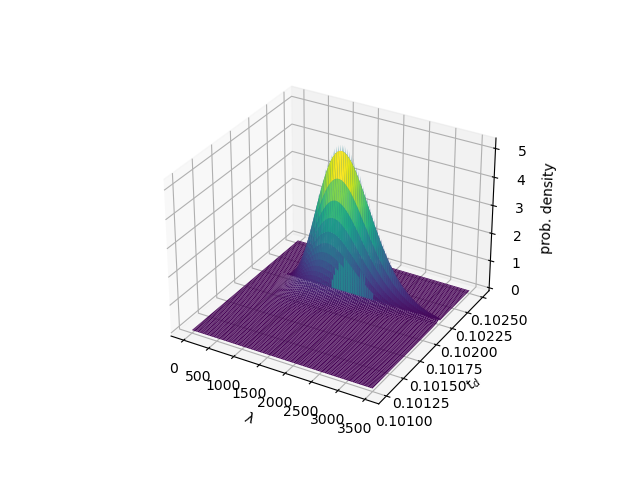

In [15]:
lam_grid2, t_d_grid2, ptheta2 = find_posterior(0.00001, 3500, 0.101, 0.1025, measurements2)
plot_ptheta_surface(lam_grid2, t_d_grid2, ptheta2)

#### 3.

*Approach:* Do exactly the same as in Programming example: plotting joint probability distributions of episode 4. Integrate along both axes to get the univariate pdfs

In [16]:
def plot_univariate_pdfs(lam_grid, t_d_grid, ptheta_norm):
    '''Plots univariate pdfs in both directions'''
    lam_pdf = spint.simpson(ptheta_norm, t_d_grid, axis=0)
    t_d_pdf = spint.simpson(ptheta_norm, lam_grid, axis=1)
    
    max_lam = lam_grid[0,np.argmax(lam_pdf)]
    max_t_d = t_d_grid[np.argmax(t_d_pdf),0]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    ax1.plot(lam_grid[0,:], lam_pdf)
    ax1.set_title('$\lambda$ univariate pdf')
    ax1.set_xlabel('$\lambda$')
    ax1.set_ylabel('prob. density')
    ax1.text(0.55,0.9,f'Max. $\lambda=${round(max_lam,3)}', transform=ax1.transAxes)
    ax2.plot(t_d_grid[:,0], t_d_pdf)
    ax2.set_title('$t_d$ univariate pdf')
    ax2.set_xlabel('$t_d$')
    ax2.set_ylabel('prob. density')
    ax2.text(0.05,0.9,f'Max. $t_d=${round(max_t_d,5)}', transform=ax2.transAxes)
    plt.show()

<IPython.core.display.Javascript object>


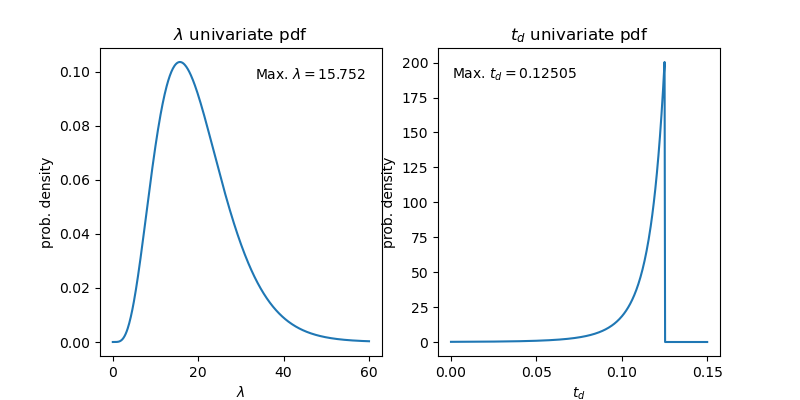

In [17]:
plot_univariate_pdfs(lam_grid1, t_d_grid1, ptheta1)

<IPython.core.display.Javascript object>


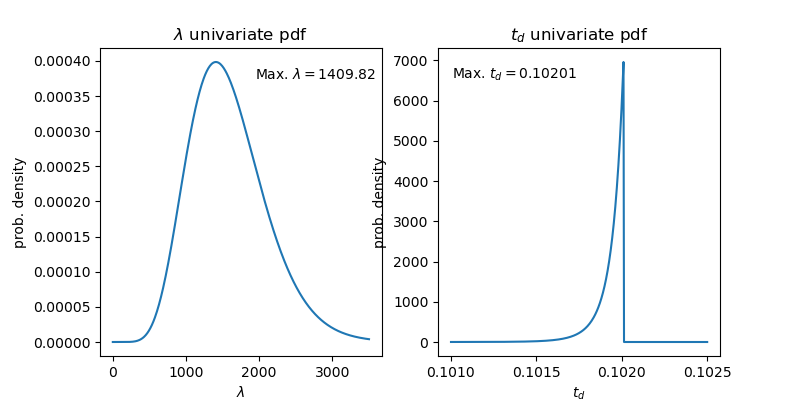

In [18]:
plot_univariate_pdfs(lam_grid2, t_d_grid2, ptheta2)

From the univariate pdfs, we can see that the dead time, $t_d$, for the two samples are different.

#### 4.

*Approach:* Add an option to have the $t_d$ prior be a normal distribution instead of a uniform distribution.

*Note:* Instead of integrating the prior before taking the sum of the logs (see comment in function), I should have multiplied by the prior itself, however I didn't have time to implement this properly. 

<IPython.core.display.Javascript object>


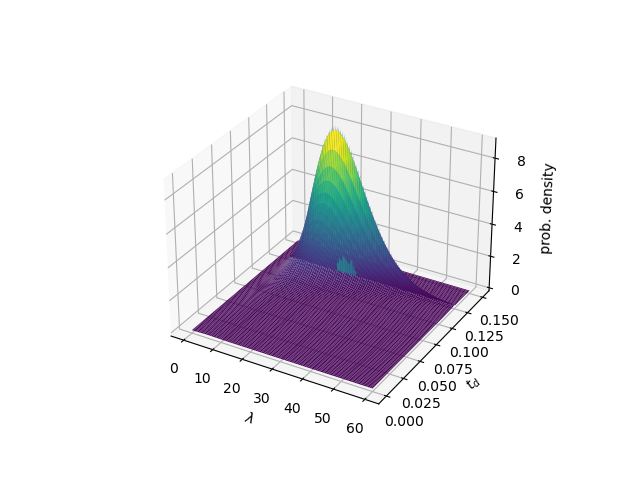

<IPython.core.display.Javascript object>


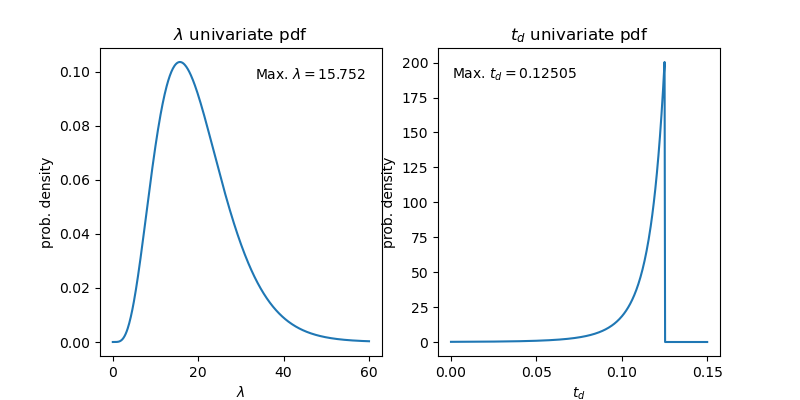

In [19]:
lam_grid_n1, t_d_grid_n1, ptheta_n1 = find_posterior(0.00001, 60, 0, 0.15, measurements1, uniform_t_d=False)
plot_ptheta_surface(lam_grid_n1, t_d_grid_n1, ptheta_n1)
plot_univariate_pdfs(lam_grid_n1, t_d_grid_n1, ptheta_n1)

<IPython.core.display.Javascript object>


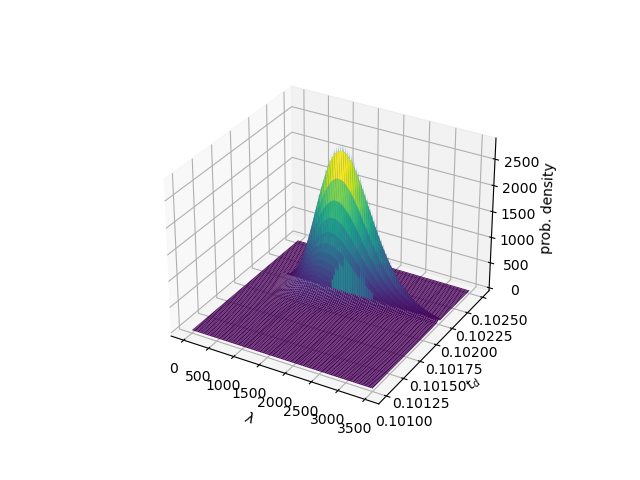

<IPython.core.display.Javascript object>


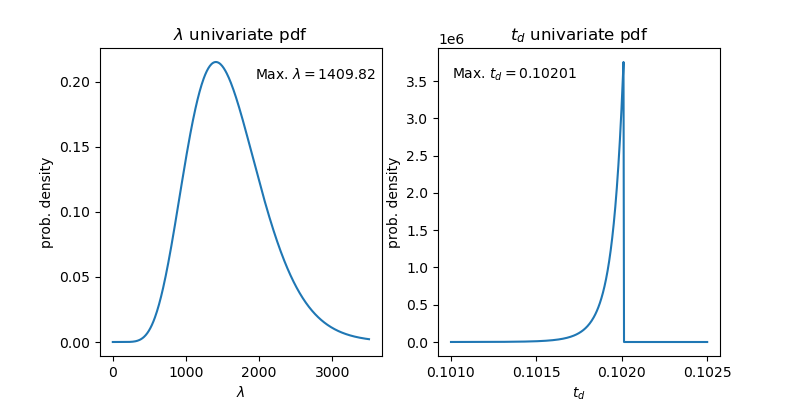

In [20]:
lam_grid_n2, t_d_grid_n2, ptheta_n2 = find_posterior(0.00001, 3500, 0.101, 0.1025, measurements2, uniform_t_d=False)
plot_ptheta_surface(lam_grid_n2, t_d_grid_n2, ptheta_n2)
plot_univariate_pdfs(lam_grid_n2, t_d_grid_n2, ptheta_n2)